# **Hedger Simulation and Pricing Example**

*Driven by* `deep-hedging` *library*.

In [1]:
!pip install deep_hedging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.3 MB/s eta 0:00:00
  Created wheel for deep_hedging: filename=deep_hedging-2.0-py3-none-any.whl size=77036 sha256=00c4e893549e5dad0ece876cb2e3bfe586108f5a18a564aa9eeaf751471e415b
  Stored in directory: /root/.cache/pip/wheels/d9/c2/a5/e4cc04aa133886b79d5e58b2ba1e147addc8940d31e932b5a0
Successfully built deep_hedging


Import useful tools.

In [2]:
import datetime as dt
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging import Hedger
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

Specify the parameters of the option to simulate.

In [3]:
@dataclass
class InstrumentParams:
    N_PATHS: int = 200_000
    N_STOCKS: int = 1
    TILL_MATURITY: float = 3.0
    N_DAYS: int = int(round(365 * TILL_MATURITY))
    RF_RATE: float = 0.03
    STRIKE_LEVEL: float = 1.0 # expressed as decimal of spot
    VOL: float = 0.2

## Simulate Stock Paths by Monte Carlo

Create (an) Asset with the specified above parameters.

*   Here the assumption of the **stock mean return being equal to risk-free rate** (due to the market completness, i.e., being able to hedge out any risk by its fair price) is used;
*   Another way to look at it is mathematically with the help of Girsanov's Theorem that allows to substitute the measure space.

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=InstrumentParams.N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(InstrumentParams.N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * InstrumentParams.N_STOCKS),
    means=np.array([InstrumentParams.RF_RATE] * InstrumentParams.N_STOCKS),
    var_covar=np.array([InstrumentParams.VOL**2] * InstrumentParams.N_STOCKS),
)

Create the yield curve of interest rates. Assume that it is flat everywhere at the level of RF_RATE%.

In [5]:
curve = ConstantRateCurve(constant_rate=InstrumentParams.RF_RATE)

Create the European Call with the parameters above.

In [6]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=InstrumentParams.STRIKE_LEVEL,
    start_date=start,
    end_date=end,
)

Introduce the discount factor for future operations here.

In [7]:
discount_factor = np.exp(-InstrumentParams.RF_RATE * european_call.time_till_maturity)

In [8]:
simulator = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)
paths = simulator.get_paths(
    spot=[1.0],
    time_till_maturity=InstrumentParams.TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([InstrumentParams.VOL**2] * len(t)),
    n_paths=InstrumentParams.N_PATHS,
).squeeze(2)
paths.shape

(200000, 1096)

## Simulate Delta-Hedging

In this section the simulation process of delta-hedging procedure is introduced. As we can simulate the path-dependant rules to hedge, we can produce the resulting **metrics of the hedging portfolio, accounting for spot movements and interest rate costs on self-financing portfolio**.

Few words on the `Hedger` parameters:

*   uses the instrument to produce the hedging process for this particular instrument inside;
*   specifies hedging mode, according to the ones, implemented in the library;
*   uses parameter of `look_ahead`. By default it is set to `False`, meaning that if we observe spot $S_t$ at the time $t$ and use it to calculate the hedging weight $\mathcal{w}(S_t)$ (e.g., delta of an option as $\mathcal{\Delta}(S_t)$), then the trade to adjust hedge position in accordance with this weight is conducted only at $S_{t + 1}$. However, as BSM model uses assumption of instantenious trading and hedging (frictionless market), it is allowed to set it to `True`, then calculating the hedge and trading it will be done at the same time with same $S_t$.



In [9]:
hedger = Hedger(
    european_call,
    look_ahead=True
)

Let's calculate portfolio metrics.

In [10]:
simulation_params = {
    "bids": paths,
    "asks": paths,
    "rates_lend": curve(european_call.days_till_maturity) / 365,
    "rates_borrow": curve(european_call.days_till_maturity) / 365,
}
pnl_hedge, payoff_opt = hedger.simulate(**simulation_params)

print(f"Mean hedging portfolio PnL = {pnl_hedge.mean() * 100:.7f}%")
print(f"Mean option's payoff = {payoff_opt.mean() * 100:.7f}%")

Mean hedging portfolio PnL = -0.0541843%
Mean option's payoff = 19.5379595%


In [11]:
print(f"Vol of option's payoff = {payoff_opt.std() * 100:.7f}%")
print(f"Vol of hedging portfolio PnL = {pnl_hedge.std() * 100:.7f}%")
print(f"Vol of [option + hedging operations] portfolio PnL = {(pnl_hedge - payoff_opt).std() * 100:.7f}%")

Vol of option's payoff = 30.1549431%
Vol of hedging portfolio PnL = 30.1098828%
Vol of [option + hedging operations] portfolio PnL = 0.3733529%


Why the volatility of the composition is such? **Let's look at the correlation matrix**.

In [12]:
np.corrcoef(pnl_hedge, payoff_opt)

array([[1.        , 0.99992436],
       [0.99992436, 1.        ]])

Let's calculate the price by the Hedging Simulation procedure.

In [13]:
# Calculate mean difference
future_value = (payoff_opt - pnl_hedge).mean()
present_value = future_value * discount_factor
print(f"Hedge Simulation-based price = {present_value * 100:.7f}%")

Hedge Simulation-based price = 17.9058712%


In [14]:
print(f"Hedge Simulation-based price = {hedger.price(**simulation_params) * 100:.7f}%")
print(f"Black-Scholes-Merton price = {european_call.price().item() * 100:.7f}%")

Hedge Simulation-based price = 17.9058712%
Black-Scholes-Merton price = 17.8995274%


Remember that theoretically the price of a derivative is the present value of the risk-neutral expected value of its payoff. Therefore, the price of the option is given as simply:

In [15]:
monte_carlo_price = payoff_opt.mean() * discount_factor
print(f"Monte Carlo price = {monte_carlo_price * 100:.7f}%")

Monte Carlo price = 17.8563505%


However, such an approach does not yield consistent results in practice - **the Hedging Strategy might have frictions** (bid-offer spread, non-equal borrowing and lending rates, broker commissions etc.). Therefore, **the Hedge Simulation based pricing can account for that, while usual Monte Carlo for the payoff cannot**.

## Check the logic via charts

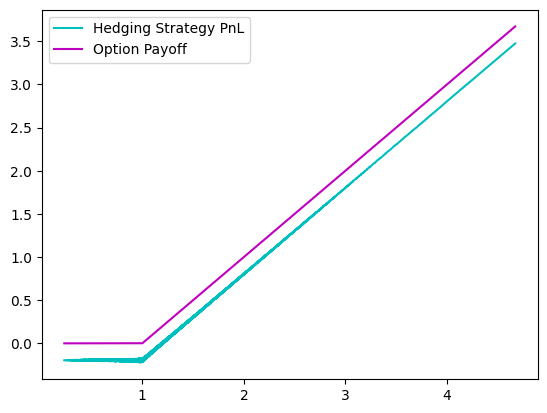

In [16]:
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])], "c")
plt.plot(np.sort(paths[:, -1]), payoff_opt[np.argsort(paths[:, -1])], "m")
plt.legend(["Hedging Strategy PnL", "Option Payoff"])
plt.show()

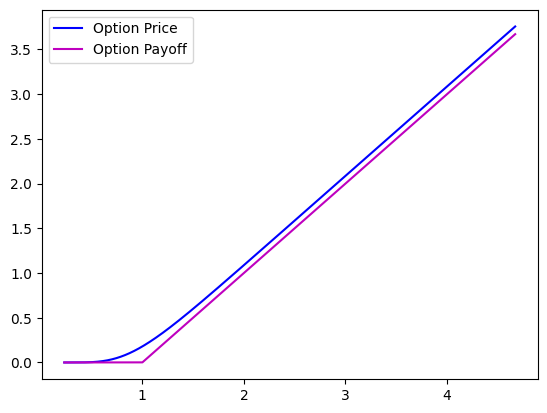

In [17]:
value_opt = european_call.price(spot=paths[:, -1])

plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])], "b")
plt.plot(np.sort(paths[:, -1]), payoff_opt[np.argsort(paths[:, -1])], "m")
plt.legend(["Option Price", "Option Payoff"])
plt.show()

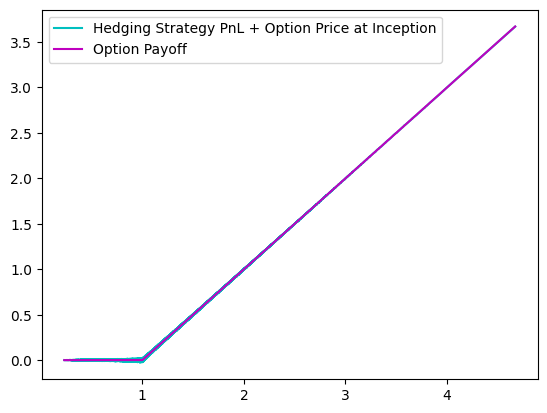

In [18]:
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1) / discount_factor,
    "c"
)
plt.plot(np.sort(paths[:, -1]), payoff_opt[np.argsort(paths[:, -1])], "m")
plt.legend(["Hedging Strategy PnL + Option Price at Inception", "Option Payoff"])
plt.show()

Then what do we get as our trading book portfolio? The returns are below.

In [19]:
portfolio = pnl_hedge + european_call.price().T.squeeze(1) / discount_factor - payoff_opt

print(f"Mean trading portfolio PnL = {portfolio.mean() * 100:.7f}%")
print(f"Vol of trading portfolio PnL = {portfolio.std() * 100:.7f}%")

Mean trading portfolio PnL = -0.0069412%
Vol of trading portfolio PnL = 0.3733529%
